In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from scipy.optimize import curve_fit
from functools import reduce 

In [2]:
class DiseaseStatus(Enum):  
    SUSCEPTIBLE = 0
    INFECTIOUS = 1
    RECOVERED = 2
    DEAD = 3

class AgeStatus(Enum):
    YOUNG = 0
    OLD = 1  
    
class Citizenship(Enum):
    STAVANGER = 0
    OSLO = 1
    BERGEN = 2
    TRONDHEIM = 3

class StateSaver:
    def __init__(self):     
        self.infectious_cumulative =[]
        self.susceptible_cumulative =[]
        self.dead_cumulative = []
        self.dead_elderly = []
        self.recoveries_cumulative =[]
        self.recoveries_elderly = []
        self.dead_young =[]
        self.recoveries_young = []



class RandomWalkEpidemicSimulator:
    """
    Class used to model the spreading of a contagious disease in a
    population of individuals with a 2D random walk.

    Each walker has a disease status which is represented by an 
    integer Enum. Also, a set of integer (x, y)-coordinates are 
    stored for each walker. The possible coordinates are:

        {0, 1, ..., Lx-1} in the x-direction
        {0, 1, ..., Ly-1} in the y-direction

    It is only possible to move North, South, East, or West. If a 
    walker attempts to move outside of the physical domain, nothing 
    happens (i.e., a "bounce-back boundary condition" is enforced).
    """


    def __init__(self,population_size, no_init_infected=1,nx=50,ny=50, q=0.9):
        """
        :param population_size: The total number of people (N).
        :param no_init_infected: The number of infected people at t=0.
        :param nx: The number of lattice nodes in the x-direction 
        :param ny: The number of lattice nodes in the y-direction.
        :param q: The probability of infection (0 <= q <= 1).
        """
        self.N_ = population_size
        self.I0_= no_init_infected
        self.nx_ = nx
        self.ny_ = ny 
        self.infection_probability_ = q
        self.nth_elderly = 3 # every nth person is elderly
        self.recovery_rate = 0.001
        self.death_rate_old = 0.005
        self.death_rate_young = 0.0005
        #self.travel_rate_susceptible = 0.15 #not used?
        self.travel_rate_asymptomatics = 0.15
        self.social_distancing_rate = 0.8
        self.social_distancing_duration = 50
        self.idx_ = np.arange(0,self.N_,1)
        
        ##### Iteration number/iteration count and infection threshold, Used in social distancing function
        self.iteration = []
        self.infection_threshold = 0.1
        self.days_between_distancings = 50
        ####
        
        #### initial citizenships
        self.STAVANGER_population = int(self.N_*0.2)
        self.OSLO_population =      int(self.N_*0.4)
        self.BERGEN_population =    int(self.N_*0.3)
        self.TRONDHEIM_population = int(self.N_*0.1)
        self.population_roundofs = self.N_ - self.STAVANGER_population - self.OSLO_population -self.BERGEN_population -self.TRONDHEIM_population

        self.STAVANGER_citizens = np.full(self.STAVANGER_population, Citizenship.STAVANGER) 
        self.OSLO_citizens = np.full(self.OSLO_population, Citizenship.OSLO) 
        self.OSLO_extra_citizens = np.full(self.population_roundofs, Citizenship.OSLO)
        self.OSLO_citizens = np.concatenate((self.OSLO_citizens, self.OSLO_extra_citizens), axis = 0)
        self.BERGEN_citizens = np.full(self.BERGEN_population, Citizenship.BERGEN) 
        self.TRONDHEIM_citizens = np.full(self.TRONDHEIM_population, Citizenship.TRONDHEIM) 

        self.Citizenship_list_ = np.concatenate((self.STAVANGER_citizens, self.OSLO_citizens,self.OSLO_extra_citizens,self.BERGEN_citizens,self.TRONDHEIM_citizens), axis = 0)

        #### Initial diseas status
        self.State_ = np.full(self.N_, DiseaseStatus.SUSCEPTIBLE)
        self.State_[0:self.I0_] = DiseaseStatus.INFECTIOUS
       
        # Generating intial walkers
        self.Walkers_ = np.random.randint(0, [self.nx_, self.ny_], size=(self.N_, 2))
        for city in Citizenship:
            self.Walkers_[self.Citizenship_list_ == city] = np.random.randint([self.get_borders(city)[1] +1,self.get_borders(city)[3]+1], [self.get_borders(city)[0]-1, self.get_borders
            (city)[2]-1], size=(len(self.Citizenship_list_[self.Citizenship_list_ == city]),2))

        
        self.Walkers_Old_ = self.Walkers_.copy()
        

        ### Cumulative holders; accessed by the save state function
        self.infectious_cumulative =[]
        self.susceptible_cumulative =[]
        self.dead_cumulative = []
        self.dead_elderly = []
        self.recoveries_cumulative =[]
        self.recoveries_elderly = []


        # Age states
        self.AgeState_ = np.full(self.N_, AgeStatus.YOUNG)
        self.AgeState_[np.arange(0,self.N_,self.nth_elderly)] = AgeStatus.OLD #Nth of population in every city is elderly
        


    def get_borders(self, citizen):
        borders = [[int(0.5*self.nx_),0,  int(0.5*self.ny_),0],
        [self.nx_, int(0.5*self.nx_),int(0.5*self.ny_),0],
        [int(0.5*self.nx_),0, self.ny_, int(0.5*self.ny_)],
        [self.nx_,int(0.5*self.nx_), self.ny_, int(0.5*self.ny_)]] 
        
        return borders[citizen.value]
    
    



    def is_in_invalid_position_quadrant(self, walker_index):
        x_upper, x_lower, y_upper, y_lower = self.get_borders(self.Citizenship_list_[walker_index])

        walker = self.Walkers_[walker_index]

        x_check = any([walker[0] >= x_upper , walker[0] <= x_lower])
        y_check =any([walker[1] >= y_upper, walker[1] <=y_lower])
        return x_check or y_check


    def move_walkers_old_and_young(self):
        self.Walkers_Old_ = self.Walkers_.copy()
        youngcount = len(self.AgeState_[self.AgeState_==AgeStatus.YOUNG]) 
        oldagecount = len(self.AgeState_[self.AgeState_==AgeStatus.OLD]) 
        
        young_step_index =np.random.randint(0,4, size =(youngcount))
        oldage_step_index = np.random.randint(0,5, size =(oldagecount))

        next_steps = np.array([[0,1], [1,0], [0,-1], [-1,0],[0,0]])     # 1/5th of the times, [0,0] (no movement) is performed by OldAge walkers

        self.Walkers_ += next_steps[np.concatenate((oldage_step_index,young_step_index), axis =0)]
       
        for walker_index in range(self.N_):
            if self.is_in_invalid_position_quadrant(walker_index):
                self.Walkers_[walker_index] = self.Walkers_Old_[walker_index]   
    
    def city_travel(self):
        """Function that dictates travelling between cities, with a few assumptions:
        Only susceptible and infectious can travel, (the infectious are "asymptomatic" or break quarantine rules)
        because dead people don't travel very often, pluss it would be intereseting to plot the death toll for each city. 
        """
        traveler_index = np.random.randint(0,self.N_)       
        # if self.State_[traveler_index] == DiseaseStatus.SUSCEPTIBLE or self.State_[traveler_index] == DiseaseStatus.RECOVERED and np.random.random() < self.travel_rate_susceptible:
        #         destination_index = (self.Citizenship_list_[traveler_index].value + np.random.randint(0,4))%4
        #         destination = Citizenship(destination_index)
                
        #         self.Walkers_[traveler_index] =  np.random.randint([self.get_borders(destination)[1] +1,self.get_borders(destination)[3]+1], [self.get_borders(destination)[0]-1,
        #         self.get_borders(destination)[2]-1])
        #         self.Citizenship_list_[traveler_index] = destination

        if self.State_[traveler_index] == DiseaseStatus.INFECTIOUS and np.random.random() < self.travel_rate_asymptomatics:
                destination_index = (self.Citizenship_list_[traveler_index].value + np.random.randint(0,4))%4
                destination = Citizenship(destination_index)
                
                self.Walkers_[traveler_index] =  np.random.randint([self.get_borders(destination)[1] +1,self.get_borders(destination)[3]+1], [self.get_borders(destination)[0]-1,
                self.get_borders(destination)[2]-1])
                self.Citizenship_list_[traveler_index] = destination
        else:
            pass



    
    
    def collision(self):
        infectious_index = self.idx_[self.State_ == DiseaseStatus.INFECTIOUS]
        susceptible_index = self.idx_[self.State_==DiseaseStatus.SUSCEPTIBLE]
        
        infectious_locations = self.Walkers_[self.State_ == DiseaseStatus.INFECTIOUS]
        susceptible_location = self.Walkers_[self.State_ == DiseaseStatus.SUSCEPTIBLE]
        
        for infected_cord in infectious_locations:
            x_intersect = np.where(infected_cord[0] == susceptible_location[:,0])[0]
            y_intersect = np.where(infected_cord[1] == susceptible_location[:,1])[0]
            
            x_suscept = susceptible_index[x_intersect]
            y_suscept = susceptible_index[y_intersect]
            
            
            x_y_suscept_intersect =np.intersect1d(x_suscept,y_suscept)

            if x_y_suscept_intersect.size >0:
                for intersect in x_y_suscept_intersect:
                    #print(self.Walkers_[intersect],infected_cord)
                    if np.random.randint(0,1) < self.infection_probability_:
                        self.State_[intersect] = DiseaseStatus.INFECTIOUS
                    else:
                        pass
        
    def death_and_recovery(self):
        infected_indices = self.idx_[self.State_ == DiseaseStatus.INFECTIOUS]
        
        for inf_index in infected_indices:
            if self.AgeState_[inf_index] == AgeStatus.OLD:
                if np.random.random() <self.death_rate_old:
                    self.State_[inf_index] = DiseaseStatus.DEAD
                elif np.random.random() < self.recovery_rate:
                    self.State_[inf_index] = DiseaseStatus.RECOVERED
            else: 
                if np.random.random() <self.death_rate_young:
                    self.State_[inf_index] = DiseaseStatus.DEAD
                elif np.random.random() < self.recovery_rate:
                    self.State_[inf_index] = DiseaseStatus.RECOVERED
    
    def social_distancing(self, i):
        """When number of infected reaches a certain percentage of population
        'social distancing' is enacted (Some probability of no movements in a time step)
        this plot returns a boolean, this is enctde two times  """
        amount_of_infected = len(self.State_[self.State_ == DiseaseStatus.INFECTIOUS])
        if len(self.iteration) < self.social_distancing_duration:
            if amount_of_infected> self.infection_threshold*self.N_ and np.random.random() < self.social_distancing_rate:
                self.iteration.append(i)
                #print(self.iteration)
                return True
            else:
                return False
        elif len(self.iteration) > self.social_distancing_duration and len(self.iteration)<3*len(self.social_distancing_duration) and (self.iteration[-1] -i)<self.days_between_distancings:  
             if np.random.random() < self.social_distancing_rate:
                self.iteration.append(i)
                print(self.iteration)
                return True
        else:
            return False



        


    
        
    def plot_current_state(self):     
        infectious_locations = self.Walkers_[self.State_ == DiseaseStatus.INFECTIOUS]
        susceptible_locations = self.Walkers_[self.State_ == DiseaseStatus.SUSCEPTIBLE]
        dead_locations = self.Walkers_[self.State_ == DiseaseStatus.DEAD]
        recovered_locations = self.Walkers_[self.State_ == DiseaseStatus.RECOVERED]

        
        popfig, ax =plt.subplots(figsize =(15,15))
        plt.grid()
        plt.xlim(-1, self.nx_ +1)
        plt.ylim(-1, self.ny_+1)
        plt.xticks(np.arange(0,self.nx_+1,1))
        plt.yticks(np.arange(0,self.ny_+1,1))
        plt.axvline(x= 0.5*self.nx_)
        plt.axhline(y=0.5*self.ny_, color='r', linestyle='-')

        ax.scatter(susceptible_locations[:,0], susceptible_locations[:,1], color ='Blue', label = 'Susceptible', marker = 'v')
        ax.scatter(infectious_locations[:,0], infectious_locations[:,1], color ='Red', label = 'Infectious', marker = 'o')
        ax.scatter(recovered_locations[:,0], recovered_locations[:,1], color = 'green', label ='recovered (immune)')
        ax.scatter(dead_locations[:,0], dead_locations[:,1], color ='Grey', label = 'Dead', marker = '^')
        
    def save_current_state(self, city, saver_obj):
        """ Saviong function that takes in City (from loop), and an associated saver object (created before running simulation) and saves relevant evolution of states to the saver object
        """
        number_of_infectious = np.count_nonzero(self.State_[np.where(np.logical_and(self.State_ == DiseaseStatus.INFECTIOUS, self.Citizenship_list_ == city))], axis =0)
        number_of_susceptible = np.count_nonzero(self.State_[np.where(np.logical_and(self.State_ == DiseaseStatus.SUSCEPTIBLE,self.Citizenship_list_ == city))], axis =0)
        total_number_of_dead = np.count_nonzero(self.State_[np.where(np.logical_and(self.State_ == DiseaseStatus.DEAD, self.Citizenship_list_ == city))], axis = 0)
        
        number_of_dead_elderly = np.count_nonzero(self.State_[np.where(reduce(np.logical_and,(self.State_== DiseaseStatus.DEAD,
        self.AgeState_ == AgeStatus.OLD, self.Citizenship_list_ == city)))], axis = 0)

        number_of_dead_young = np.count_nonzero(self.State_[np.where(reduce(np.logical_and,(self.State_== DiseaseStatus.DEAD,
        self.AgeState_ == AgeStatus.YOUNG, self.Citizenship_list_ == city)))], axis = 0)
    
        total_number_of_recoveries = np.count_nonzero(self.State_[np.where(np.logical_and(self.State_ == DiseaseStatus.RECOVERED,self.Citizenship_list_ == city))], axis = 0)
        number_of_recovered_elderly = np.count_nonzero(self.State_[np.where(reduce(np.logical_and,(self.State_== DiseaseStatus.RECOVERED, self.AgeState_ == AgeStatus.OLD,
        self.Citizenship_list_ == city)))])
        number_of_recovered_young = np.count_nonzero(self.State_[np.where(reduce(np.logical_and,(self.State_== DiseaseStatus.RECOVERED, self.AgeState_ == AgeStatus.YOUNG,
        self.Citizenship_list_ == city)))])

        saver_obj.dead_cumulative.append(total_number_of_dead)
        saver_obj.dead_elderly.append(number_of_dead_elderly)  
        saver_obj.dead_young.append(number_of_dead_young)  
        saver_obj.infectious_cumulative.append(number_of_infectious)
        saver_obj.susceptible_cumulative.append(number_of_susceptible)
        saver_obj.recoveries_cumulative.append(total_number_of_recoveries)
        saver_obj.recoveries_elderly.append(number_of_recovered_elderly)
        saver_obj.recoveries_young.append(number_of_recovered_elderly)
    
    def reset_model(self):
        self.State_ = np.full(self.N_, DiseaseStatus.SUSCEPTIBLE)
        self.State_[0:self.I0_] = DiseaseStatus.INFECTIOUS
        self.Walkers_ = np.random.randint(0, [self.nx_, self.ny_], size=(self.N_, 2))
        self.Walkers_Old_ = self.Walkers_.copy()

    
    def simulate(self, iterations,saver_object_list):
        """ 
        """
        for i in range(iterations):
            
            for city in Citizenship:
                self.save_current_state(city, saver_object_list[city.value])
            if self.social_distancing(i) == False: 
                self.move_walkers_old_and_young()
            self.city_travel()
            #if i % 500 == 0:
            #    self.plot_current_state()
            self.death_and_recovery()
            self.collision()
        self.__init__(self.N_, self.I0_,self.nx_,self.ny_)

        #self.reset_model() 
        
            
    
        
        


                                             
                
                
    
        

    



In [15]:
test_instance = RandomWalkEpidemicSimulator(population_size=700, nx =100, ny =100)

steps = 1500

city_data_saver = [StateSaver() for i in Citizenship]
test_instance.simulate(steps, city_data_saver)







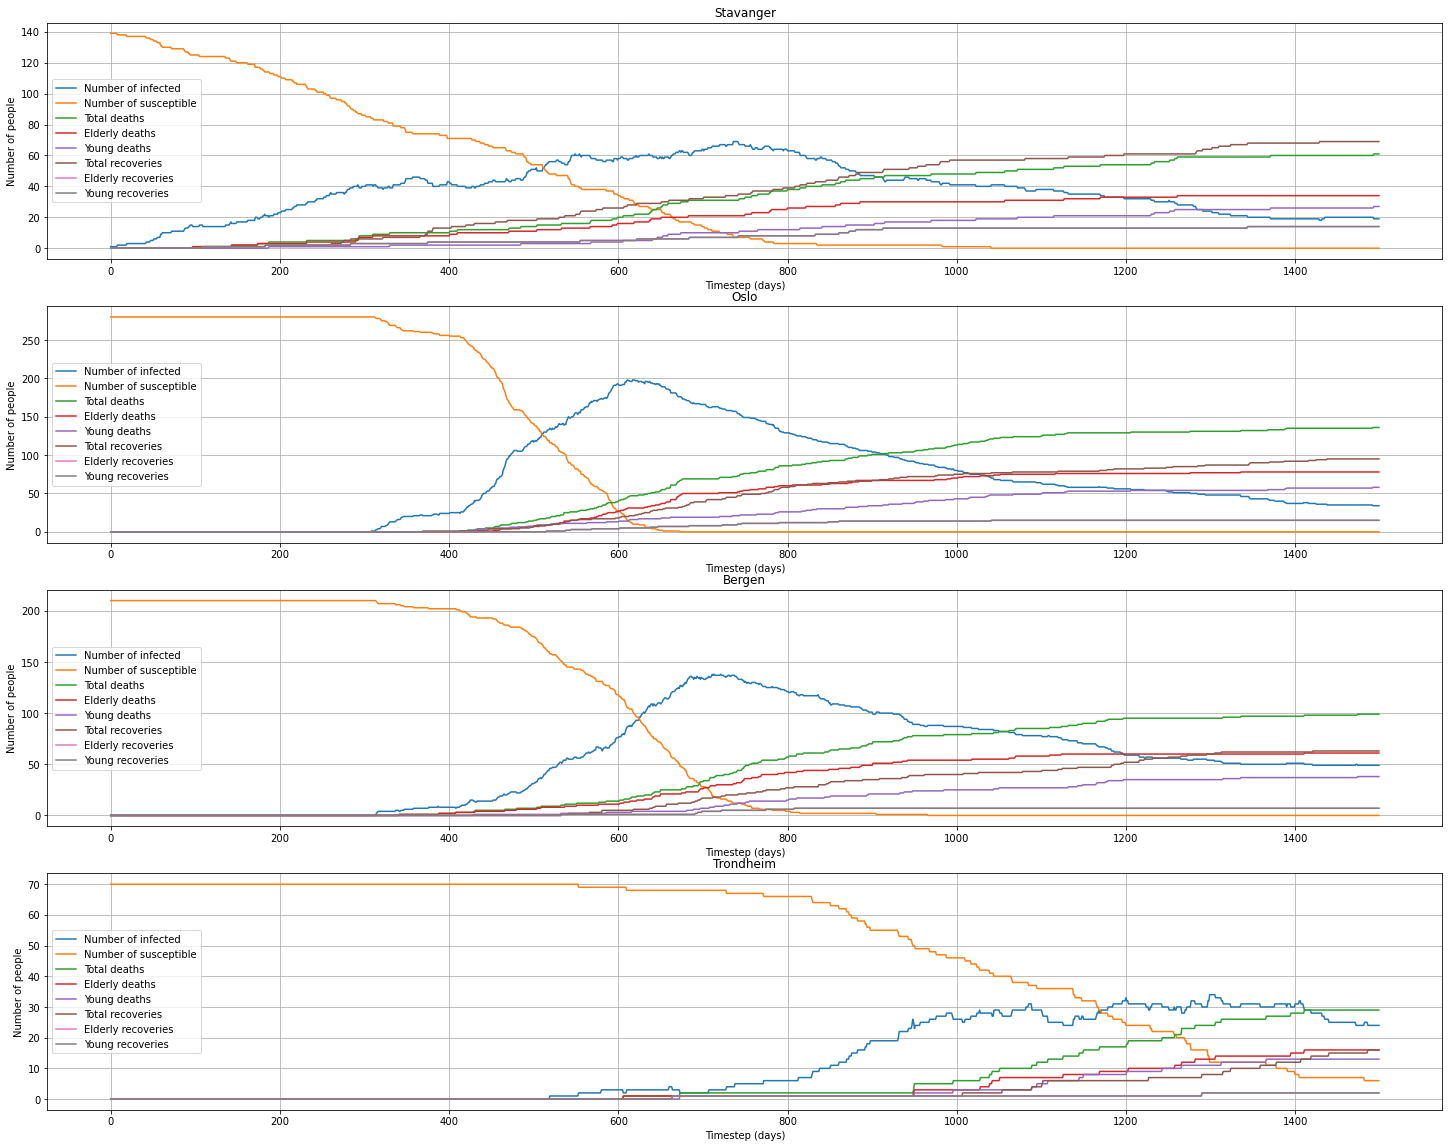

In [16]:
t =np.arange(steps)

fig, ax =plt.subplots(4, figsize = (25,20))
city_name_list = ['Stavanger', 'Oslo', 'Bergen', 'Trondheim']

for i in range(0,4):
    ax[i].plot(t,city_data_saver[i].infectious_cumulative, label ='Number of infected')
    ax[i].plot(t,city_data_saver[i].susceptible_cumulative, label = 'Number of susceptible')
    ax[i].plot(t,city_data_saver[i].dead_cumulative, label = 'Total deaths')
    ax[i].plot(t,city_data_saver[i].dead_elderly, label = 'Elderly deaths')
    ax[i].plot(t,city_data_saver[i].dead_young, label ='Young deaths')
    ax[i].plot(t,city_data_saver[i].recoveries_cumulative, label = 'Total recoveries')
    ax[i].plot(t,city_data_saver[i].recoveries_elderly, label = 'Elderly recoveries')
    ax[i].plot(t,city_data_saver[i].recoveries_young, label = 'Young recoveries')
    ax[i].grid()
    ax[i].set_ylabel('Number of people')
    ax[i].set_xlabel('Timestep (days)')
    ax[i].set_title(str(city_name_list[i]))
    ax[i].legend()

In [17]:
steps = 1500
runs = 300



def simulation_runner(runs=runs, steps=steps, population_size= 700, nx =100, ny =100, no_init_infected=1):
    """ Function that takes in siomulation parameters and runs "runs"(number of runs) simulations
    outputs runs by steps size np.arrays of healty and sick data.
    """
    simulation_instance = RandomWalkEpidemicSimulator(population_size,no_init_infected,nx,ny)
    city_data_saver = [StateSaver() for i in Citizenship]
    
    for i in range(runs):
        simulation_instance.simulate(steps, city_data_saver)
    
    infectious_data = [np.array(city_data_saver[i].infectious_cumulative).reshape(runs,steps) for i in range(4)]
    susceptible_data = [np.array(city_data_saver[i].susceptible_cumulative).reshape(runs,steps) for i in range(4)]
    dead_data = [np.array(city_data_saver[i].dead_cumulative).reshape(runs,steps)for i in range(4)]
    
    return infectious_data, susceptible_data, dead_data 

infectious_data, susceptible_data, death_data = simulation_runner()

for i in range(4):
    np.savetxt('simulation_data/Exercise4/Infectious_data_'+str(Citizenship(i).name),infectious_data[i])
    np.savetxt('simulation_data/Exercise4/Susceptible_data_'+str(Citizenship(i).name),susceptible_data[i])
    np.savetxt('simulation_data/Exercise4/Death_data_'+str(Citizenship(i).name),death_data[i])

datalist = [infectious_data, susceptible_data,death_data]

In [18]:
def simulation_plot_setup(data,data_index,city_index, t): 
    simfig, ax = plt.subplots(figsize = (15,10))

    data_lower = data.mean(axis= 0) - 0.5*data.std(axis =0)
    data_upper = data.mean(axis= 0) + 0.5*data.std(axis =0) 

    names_list = ['Susceptible', 'Infected', 'Deaths']
    main_color_list = ['Blue', 'Red', 'Green', 'Orange']
    fill_color_list =['lightblue', 'pink', 'lightgreen', 'lightsalmon' ]
    
    ax.plot(t,data.mean(axis=0), color =main_color_list[data_index], label = names_list[data_index] + str(Citizenship(city_index).name))
    ax.fill_between(t,data_lower,data_upper,color=fill_color_list[data_index] ,label ='Simulation sample-std spread')
    ax.set_title(str(Citizenship(city_index).name))
    ax.set_xlabel('Timestep (days)')
    ax.set_ylabel('Population count')
    ax.legend()
    ax.grid()
    return ax


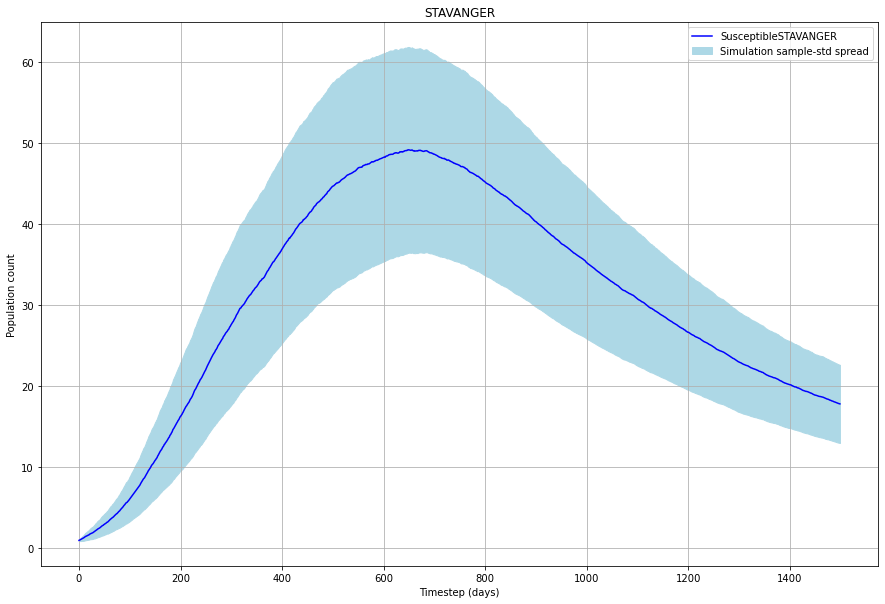

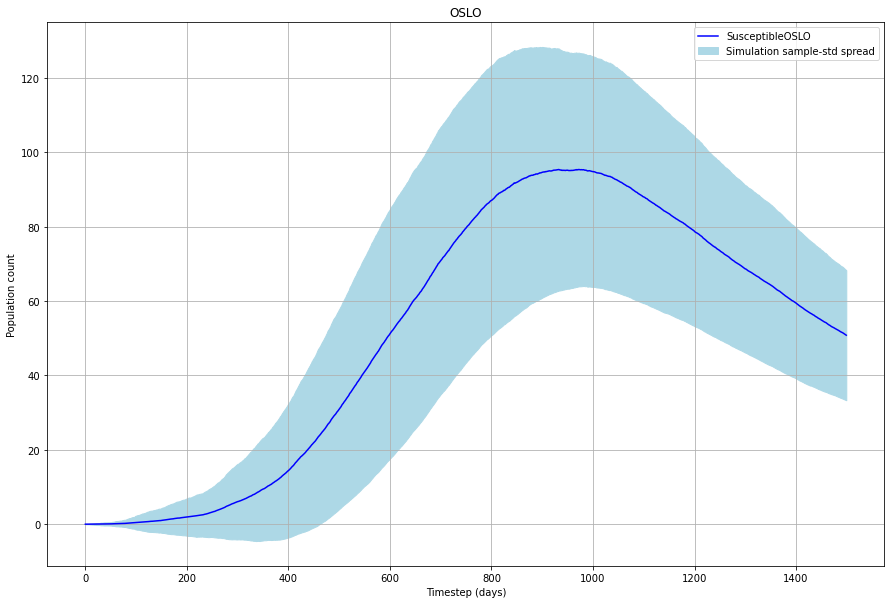

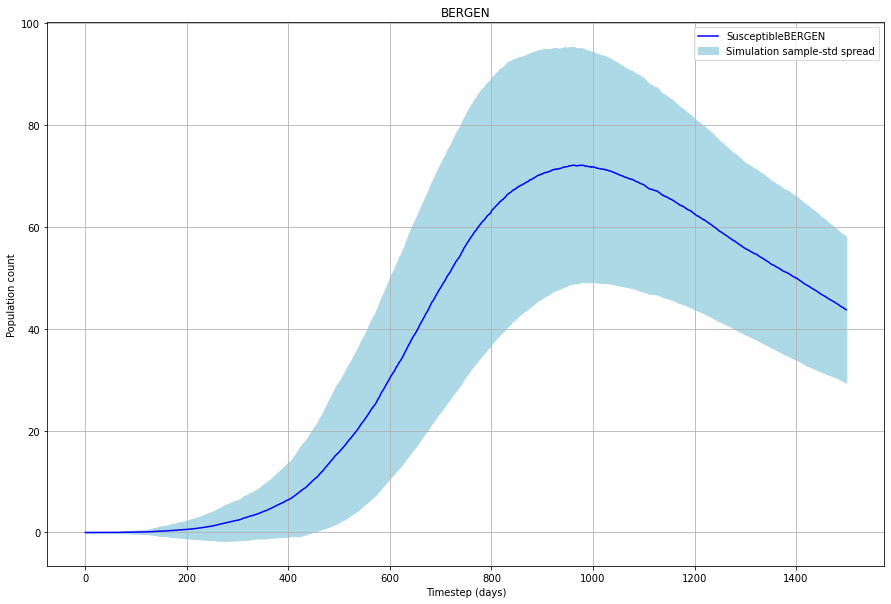

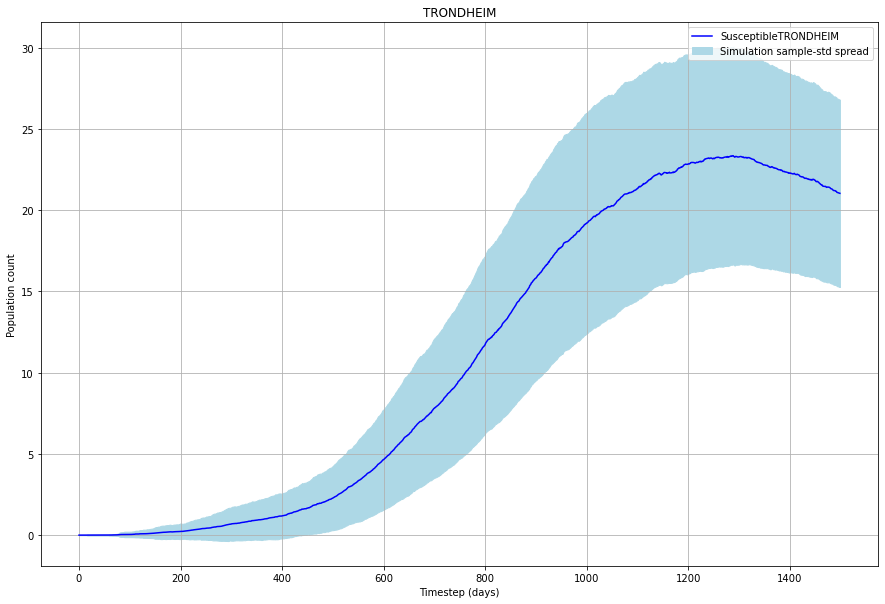

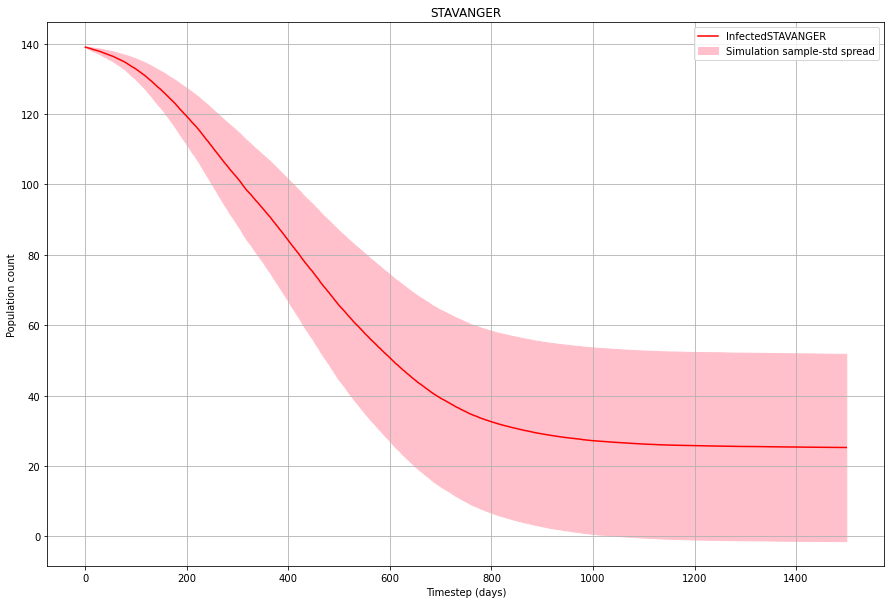

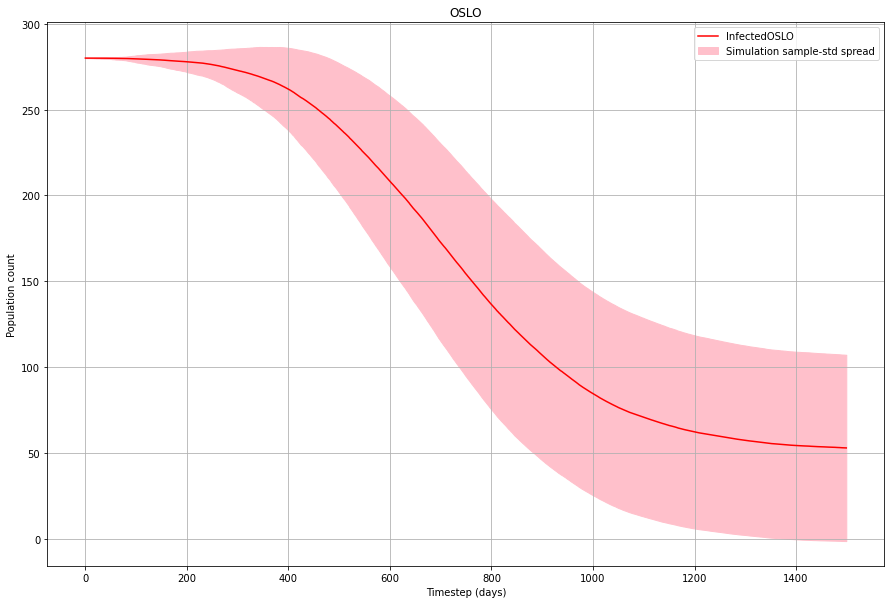

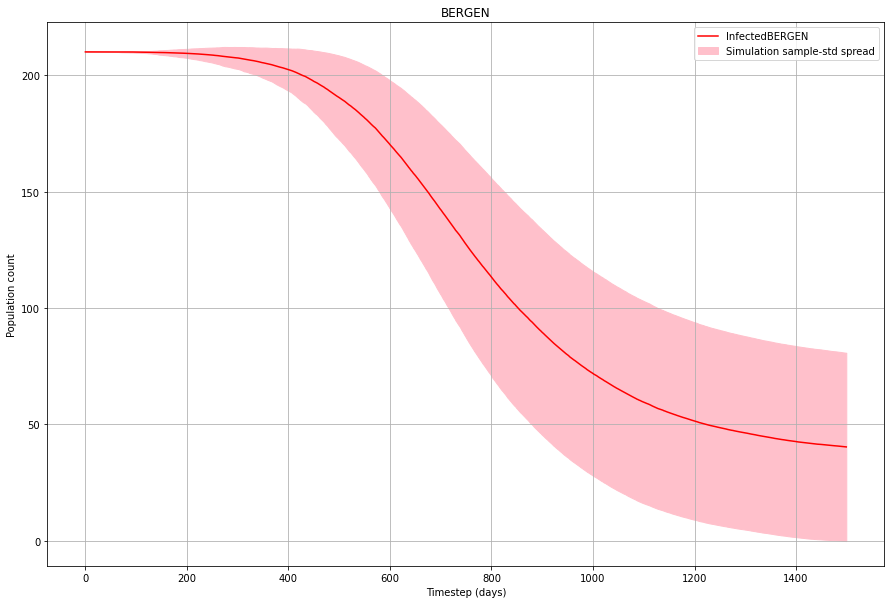

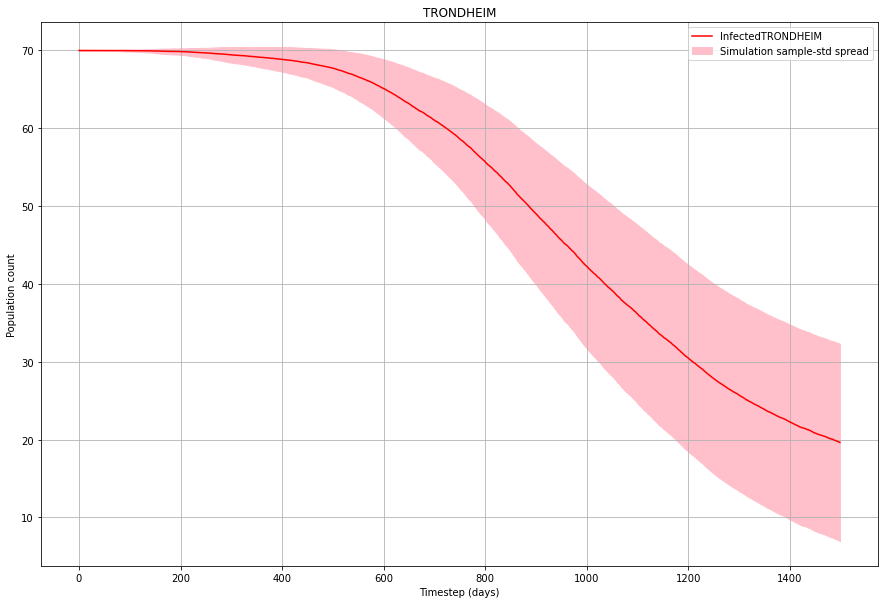

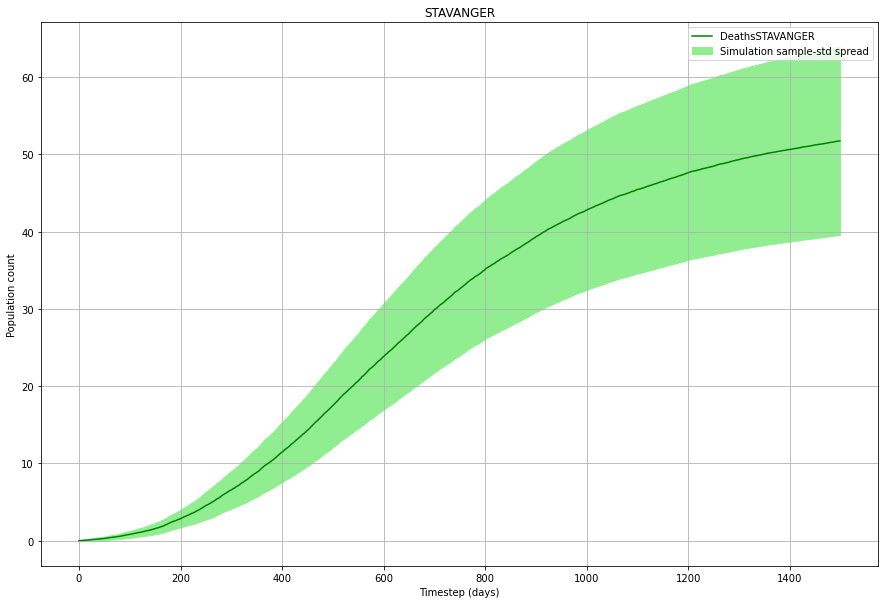

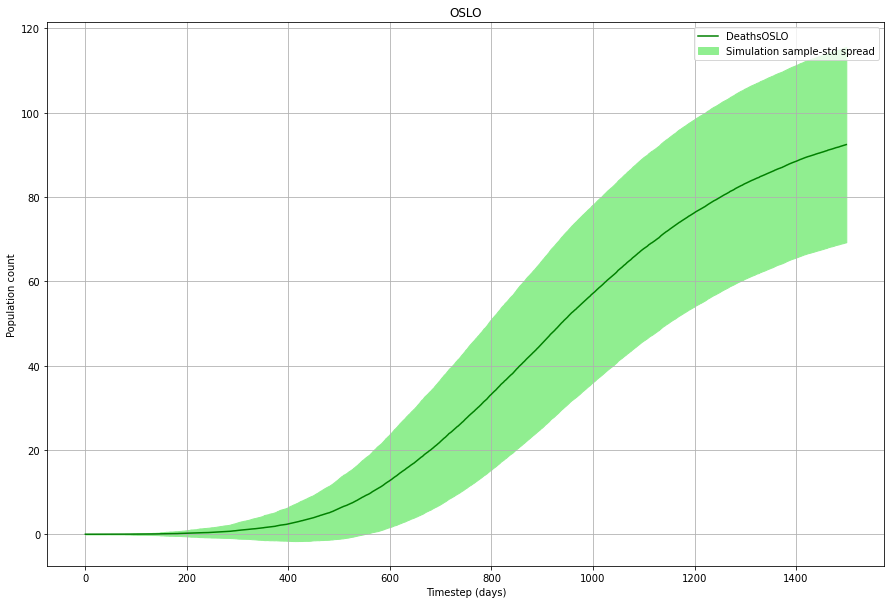

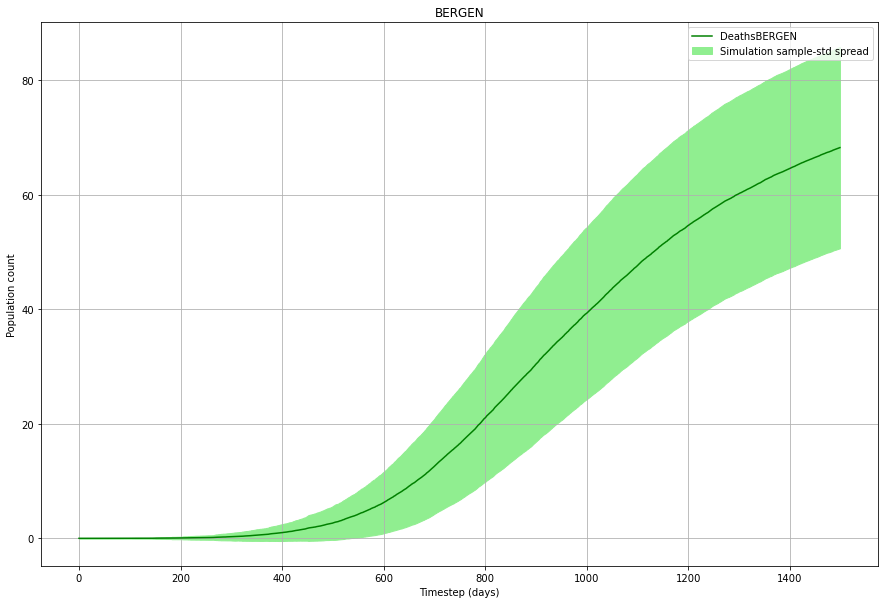

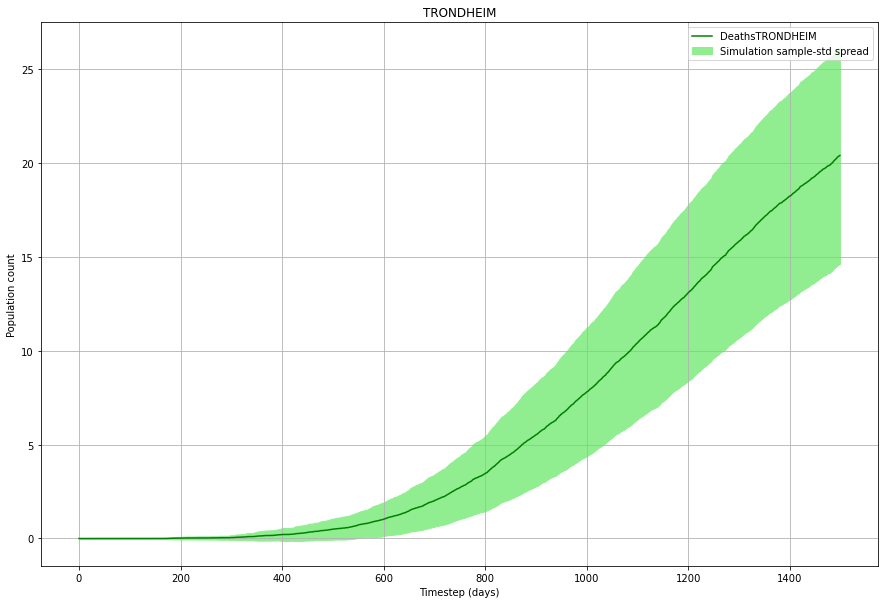

In [19]:
maybelastfig, axes = plt.subplots(figsize=(0,0))
for i in range(3):
    for j in range(4):
        simulation_plot_setup(datalist[i][j], i, j, t =np.arange(steps))


OSLO
